In [ ]:
# =========================================================
#                    IMPORTS
# =========================================================

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("../laliga.sqlite")

query = "SELECT * FROM Matches;"  # Get Matches table

# Load data into a pandas DataFrame
matches_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
print(matches_df.head())

0       2029-02-10
1       2029-02-10
2       2029-02-10
3       2029-02-10
4       2029-02-12
           ...    
29961   2068-04-28
29962   2068-04-28
29963   2068-04-28
29964   2068-04-28
29965   2068-04-28
Name: date, Length: 11294, dtype: datetime64[ns]


In [223]:
# Let's check what tables are in the database
conn = sqlite3.connect("../laliga.sqlite")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables in the database:")
for table in tables:
    print(table[0])
conn.close()

Available tables in the database:
Predictions
Matches


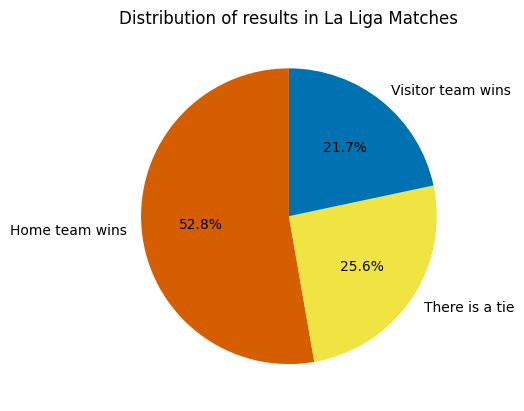

In [224]:
# Remove unplayed matches
matches_df = matches_df[matches_df["score"].notna()]
matches_df["home_goals"] = matches_df['score'].apply(lambda x: int(x.split(':')[0]) if isinstance(x, str) else None)
matches_df["away_goals"] = matches_df['score'].apply(lambda x: int(x.split(':')[1]) if isinstance(x, str) else None)
matches_df["winner"] = matches_df.apply(lambda row: 'home_team' if row['home_goals'] > row['away_goals'] else ('away_team' if row['home_goals'] < row['away_goals']  else 'draw'), axis=1)

# Count how many times each string, "home_team", "away_team" or "draw" appears
counts = matches_df['winner'].value_counts()

# Reindex with new labels for the pie chart

label_map = {
    'home_team': 'Home team wins',
    'away_team': 'Visitor team wins',
    'draw': 'There is a tie'
}

renamed_counts = counts.rename(index=label_map)


def create_pie_chart(counts, title=None):
        
    # Colorblind-friendly palette (Okabe & Ito)
    colors = [
        '#D55E00',  # vermillion
        '#F0E442',  # yellow
        '#0072B2',  # blue
        '#E69F00',  # orange
        '#56B4E9',  # sky blue
        '#009E73',  # bluish green
        '#CC79A7'   # reddish purple
    ]
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(renamed_counts)])
    plt.title(title)

    return plt.show()

create_pie_chart(renamed_counts, title='Distribution of results in La Liga Matches')





We can confirm now it is true that the home team is more likely to win.

In [225]:
# This is for all years
matches_df["date"] = pd.to_datetime(matches_df["date"])

/tmp/ipykernel_178175/3207180574.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  matches_df["date"] = pd.to_datetime(matches_df["date"])


In [226]:

def plot_weekly_distribution(df):

    df.loc[:,"weekday"] = df["date"].dt.day_name()
    df.loc[:,"year"] = df["date"].dt.year
    weekday_counts = df["weekday"].value_counts()

    # Define the correct weekday order
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Reorder the following correct week order
    weekday_counts = weekday_counts.reindex(weekday_order)

    # Create bar plot
    weekday_counts.plot(kind='bar', figsize=(8, 5))

    plt.title('Number of Matches per Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Number of Matches')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

    return None

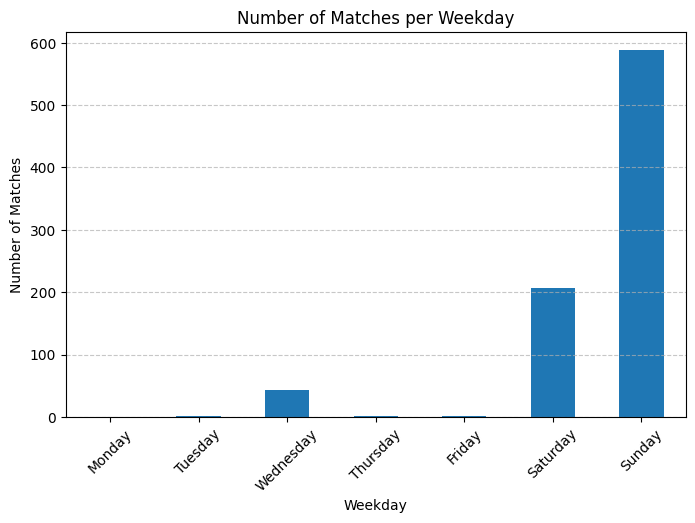

In [227]:
#Filter for 2000-2001
matches_2000 = matches_df[matches_df.season == "2000-2001"].copy()

# Plot distribution of matches per weekday
plot_weekly_distribution(matches_2000)

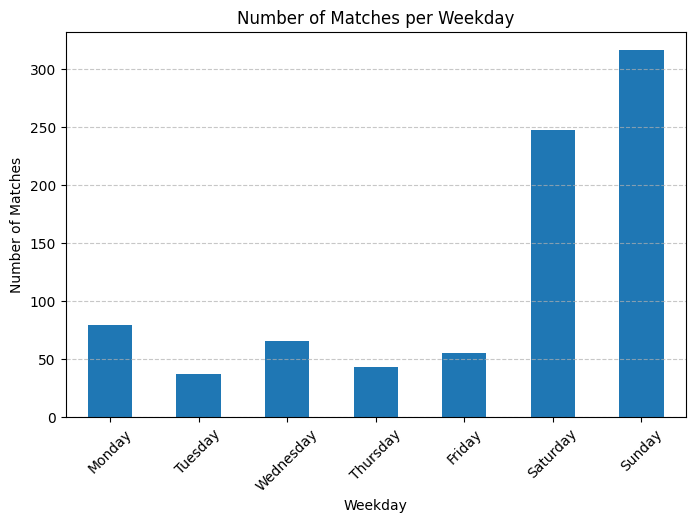

In [228]:
#Filter for 2020-2021
matches_2020 = matches_df[matches_df.season == "2020-2021"].copy()

# Plot distribution of matches per weekday
plot_weekly_distribution(matches_2020)

/tmp/ipykernel_178175/1675397130.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  matches_2000["hour"] = pd.to_datetime(matches_2000["time"])


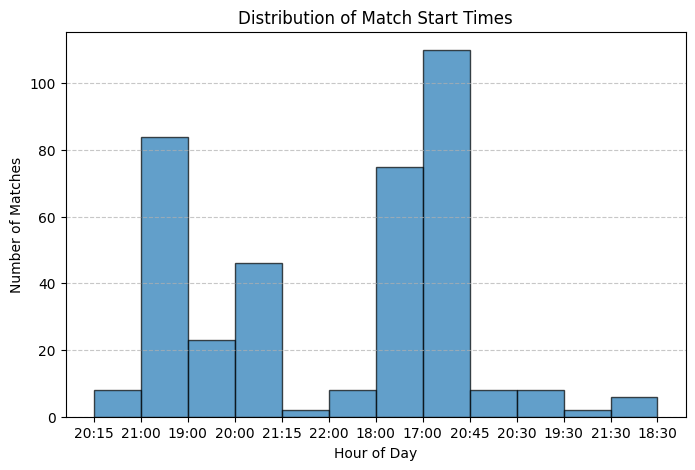

In [229]:
matches_2000 = matches_2000[matches_2000["time"].notna()].copy()
matches_2000["hour"] = pd.to_datetime(matches_2000["time"])
matches_2000["hour"] = matches_2000["hour"].dt.strftime("%H:%M")
nbins= len(matches_2000["hour"].unique())
# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(matches_2000["hour"], bins=range(0,nbins), edgecolor="black", alpha=0.7)

plt.title("Distribution of Match Start Times")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Matches")
plt.xticks(range(0,nbins))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Real Madrid has won 75 times against Barcelona.
Barcelona has won 72 times against Real Madrid.
Total goals scored by Barcelona in El Clásico matches: 290
Total goals scored by Real Madrid in El Clásico matches: 293


/tmp/ipykernel_178175/2481300519.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasico_df["Barcelona_goals"] = clasico_df.apply(lambda row: get_barcelona_goals(row), axis=1)
/tmp/ipykernel_178175/2481300519.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasico_df["Madrid_goals"] = clasico_df.apply(lambda row: get_madrid_goals(row), axis=1)


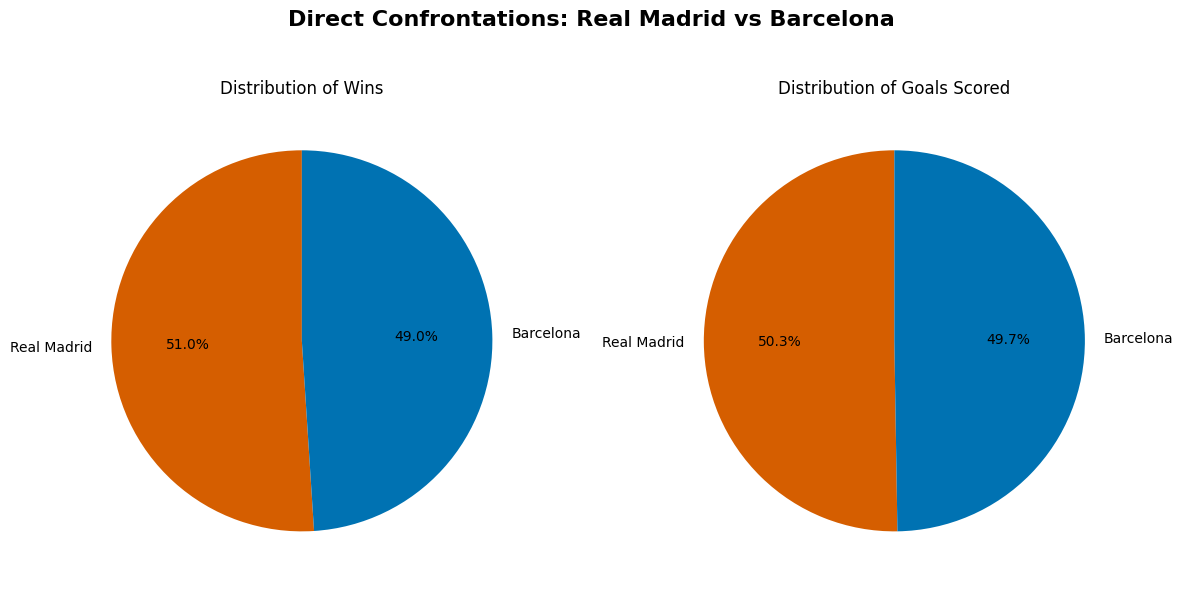

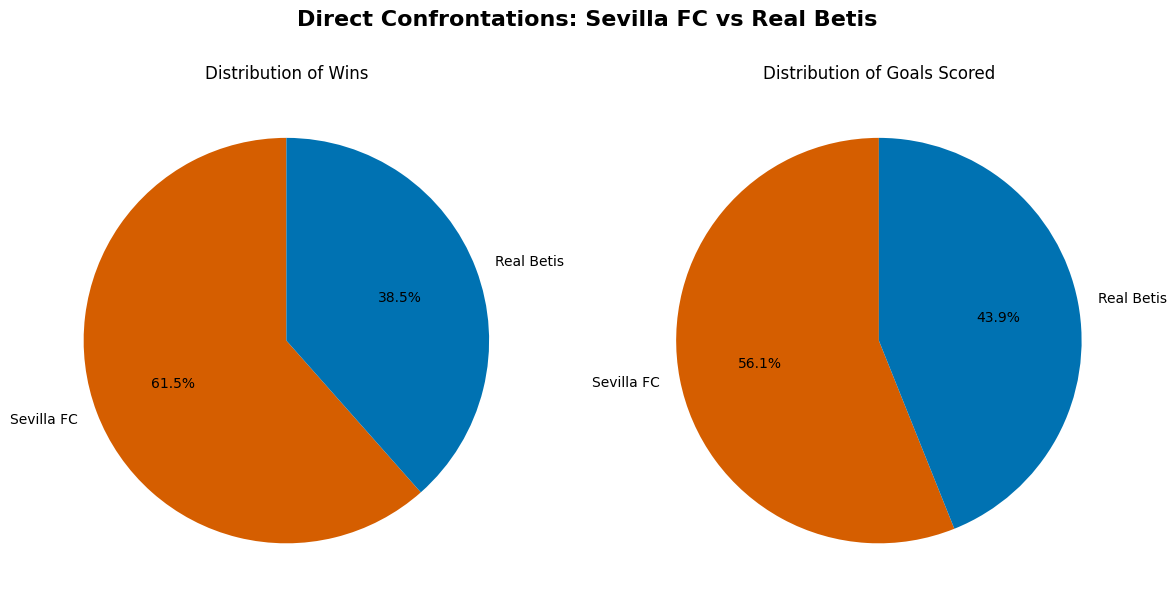

In [230]:
clasico_mask = matches_df["home_team"].isin(["Real Madrid", "Barcelona"]) & matches_df["away_team"].isin(["Real Madrid", "Barcelona"])
clasico_df = matches_df[clasico_mask]
clasico_df_wins = clasico_df[~(clasico_df["winner"] == "draw")].copy()

def get_winner_name(row):
    return row[f"{row.winner}"]
clasico_df_wins["winning_team"] = clasico_df_wins.apply(lambda row: get_winner_name(row), axis=1)    

# Madrid wins
madrid_wins = (clasico_df_wins["winning_team"] == "Real Madrid").sum()
print(f"Real Madrid has won {madrid_wins} times against Barcelona.")
# Barcelona wins
barcelona_wins = (clasico_df_wins["winning_team"] == "Barcelona").sum()
print(f"Barcelona has won {barcelona_wins} times against Real Madrid.")

# Now let's compute total goals
def get_barcelona_goals(row):
    return row["home_goals"] if row["home_team"] == "Barcelona" else row["away_goals"]

def get_madrid_goals(row):
    return row["home_goals"] if row["home_team"] == "Real Madrid" else row["away_goals"]

clasico_df["Barcelona_goals"] = clasico_df.apply(lambda row: get_barcelona_goals(row), axis=1)
clasico_df["Madrid_goals"] = clasico_df.apply(lambda row: get_madrid_goals(row), axis=1)

print(f"Total goals scored by Barcelona in El Clásico matches: {clasico_df['Barcelona_goals'].sum()}")
print(f"Total goals scored by Real Madrid in El Clásico matches: {clasico_df['Madrid_goals'].sum()}")

# Create pie charts
# clasico_counts = clasico_df_wins["winning_team"].value_counts()
def create_pie_charts(win_counts, goal_counts, title=None):
    plt.figure(figsize=(12, 6))
    # Pie chart for wins
    plt.subplot(1, 2, 1)
    colors = [
        '#D55E00',  # vermillion
        '#0072B2',  # blue
    ]
    plt.pie(win_counts, labels=win_counts.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(win_counts)])
    plt.title("Distribution of Wins")       
    # Pie chart for goals
    plt.subplot(1, 2, 2)
    plt.pie(goal_counts,labels=goal_counts.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(goal_counts)])
    plt.title("Distribution of Goals Scored") 

    # Add a global title if provided
    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()

    return plt.show()

def plot_direct_confrontations_stats(team1, team2):

    if team1 not in matches_df["home_team"].unique() and team1 not in matches_df["away_team"].unique():
        print(f"{team1} does not exist in the dataset. Available teams are: {matches_df["away_team"].unique()}")
        return
    if team2 not in matches_df["home_team"].unique() and team2 not in matches_df["away_team"].unique():
        print(f"{team2} does not exist in the dataset. Available teams are: {matches_df["away_team"].unique()}")
        return
    
    mask = matches_df["home_team"].isin([team1, team2]) & matches_df["away_team"].isin([team1, team2])
    df = matches_df[mask]
    df_wins = df[~(df["winner"] == "draw")].copy()

    def get_winner_name(row):
        return row[f"{row.winner}"]
    df_wins["winning_team"] = df_wins.apply(lambda row: get_winner_name(row), axis=1)    

    win_counts = df_wins["winning_team"].value_counts()

    def get_team1_goals(row):
        return row["home_goals"] if row["home_team"] == team1 else row["away_goals"]
    
    def get_team2_goals(row):
        return row["home_goals"] if row["home_team"] == team2 else row["away_goals"]

    goal_counts = pd.Series({
        team1: df.apply(lambda row: get_team1_goals(row), axis=1).sum(),
        team2: df.apply(lambda row: get_team2_goals(row), axis=1).sum()
    })

    return create_pie_charts(win_counts=win_counts, goal_counts=goal_counts, title=f"Direct Confrontations: {team1} vs {team2}")


plot_direct_confrontations_stats("Real Madrid", "Barcelona")
plot_direct_confrontations_stats("Sevilla FC", "Real Betis")

In [237]:
# Now, we will study elevator teams. We will define elevator teams as those that have been promoted and relegated at least 3 times
matches_df = matches_df.sort_values(['home_team', 'season'])

# Shift division to compare with previous season
matches_df['prev_division'] = matches_df.groupby('home_team')['division'].shift(1)

# Detect promotions and relegations
matches_df['promotion'] = (matches_df['prev_division'] > matches_df['division']).astype(int)
matches_df['relegation'] = (matches_df['prev_division'] < matches_df['division']).astype(int)

# Aggregate promotions and relegations per team
elevator_teams = matches_df.groupby('home_team').agg({'promotion': 'sum', 'relegation': 'sum'})

# Filter teams with at least 2 promotions and 2 relegations
elevator_teams = elevator_teams[(elevator_teams['promotion'] >= 2) & (elevator_teams['relegation'] >= 2)] 
elevator_teams

,promotion,relegation
home_team,,
Alavés,3,3
Albacete,2,2
Burgos CF,3,3
CA Osasuna,7,6
CD Alcoyano,2,2
CD Castellón,4,4
CD Logroñés,2,2
CD Málaga,3,3
CD Numancia,3,3
